In [1]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# #obs
N = train.feat_1.count()
print N

61878


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV

# === Parameter tuning - Using Hyperopt ===
from hyperopt import hp, fmin, tpe
from time import time

from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [7]:
log_loss(["spam", "ham", "ham", "spam"],  [[.1, .9], [.9, .1], [.8, .2], [.35, .65]])

0.21616187468057912

[.1, .9] - 0.1 predicted probability for class 0 and 0.9 predicted probability for class 1 <br/>
class 0 - ham, class 1 - spam <br/>
By default, spam is 1, and ham is 0

In [19]:
y_true = [0, 0, 1, 1]
y_pred = [[.9, .1], [.8, .2], [.3, .7], [.01, .99]]
log_loss(y_true, y_pred)   

0.17380733669106746

In [65]:
log_loss(["Class_1", "Class_2"], [ [0.9, 0.1], [0.1, 0.9] ]  )

0.10536051565782628

In [66]:
-(1*log(0.9) + 1*log(0.9)) / 2.0

0.10536051565782628

#Blending RF

In [5]:
kf = StratifiedKFold(train.target.values, n_folds=5, shuffle=False, random_state=26)

In [8]:
for index, (train_index, test_index) in enumerate(kf):
    train_cv, test_cv = train.values[train_index], train.values[test_index]
    pd.DataFrame(train_cv).to_csv("train_cv" + str(index) + ".csv", index=False)
    pd.DataFrame(test_cv).to_csv("test_cv" + str(index) + ".csv", index=False)
    print np.shape(test_cv)

(12378, 95)
(12377, 95)
(12376, 95)
(12376, 95)
(12371, 95)


In [ ]:
def run_blending_rf( X_train, y_train, max_depth_set, weights, kf):
    
    kf = StratifiedKFold(y_train, n_folds=5, shuffle=False)
    X = X_train
    y = y_train
    
    train_cv_error = np.empty( 5 ) 
    test_cv_error  = np.empty( 5 )

    params = {'n_estimators': 300, 'max_depth': 36, 'min_samples_leaf': 1, 'max_features': 0.1,
              'n_jobs': 16}
    
    for index, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        predicted_proba = np.zeros( (np.shape(y_test)[0], 9) )
        
        print "training for fold ", str(index)
        for i, max_depth in enumerate(max_depth_set):
            params['max_depth'] = max_depth
            print "train model with max_depth ", max_depth
            rf_model = RandomForestClassifier(**params)
            rf_fit = rf_model.fit(X_train, y_train)  
        
            # use calibrated classifier on training part
            cal_rf_fit = CalibratedClassifierCV(rf_fit, method="isotonic", cv = 40)
            cal_rf_fit.fit(X_train, y_train)  
            predicted = cal_rf_fit.predict_proba(X_test)
            
            print "write predictions to file\n"
            pd.DataFrame(predicted).to_csv("predicted_RF_depth" + str(max_depth) + "_fold" + str(index) + ".csv")
            
            predicted_proba = predicted_proba + weights[i]*predicted / np.sum(weights)
        
        test_cv_error[index]  = log_loss( y_test, predicted_proba ) 

    test_error  = np.mean(test_cv_error)
    return test_error


#Scoring on LB

In [6]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train.target

In [6]:
params = {'n_estimators': 300, 'max_depth': 40, 'min_samples_leaf': 1, 'max_features': 0.1,
          'n_jobs': 16}
  
X = np.power(X_train.values, 1.0/3)
y = y_train.values
X_test = test.drop('id', axis=1)
# predicted_proba = np.zeros( (np.shape(X_test)[0], 9) )

print "run model m40"
rf_m40 = RandomForestClassifier(**params)
rf_m40 = rf_m40.fit(X, y)  
        
# use calibrated classifier on training part
print "calibrate"
cal_rf_fit = CalibratedClassifierCV(rf_m40, method="isotonic", cv = 40)
cal_rf_fit.fit(X, y)  
predicted_m40 = cal_rf_fit.predict_proba( np.power(X_test.values, 1.0/3) )
print "---- DONE ----"

run model m40
calibrate
---- DONE ----


In [10]:
predicted_m36 = pd.read_csv("test_predicted_rf36.csv")
predicted_m38 = pd.read_csv("test_predicted_rf38.csv")
predicted_m40 = pd.read_csv("test_predicted_rf40.csv")

In [13]:
predicted_m40.values[:2]

array([[  1.22046765e-03,   1.05586333e-01,   1.53380333e-01,
          7.26938856e-01,   0.00000000e+00,   2.21182598e-03,
          9.60289921e-03,   5.16762481e-04,   5.42522655e-04],
       [  4.82134142e-03,   3.30814854e-04,   1.48210121e-03,
          1.74532071e-03,   1.06536117e-04,   6.79609525e-01,
          4.52794033e-03,   3.06210731e-01,   1.16568943e-03]])

In [14]:
predicted_rf = ( predicted_m36.values + predicted_m38.values + predicted_m40.values ) / 3.0

In [31]:
predicted_rf[:2]

array([[  1.20060988e-03,   1.05325139e-01,   1.56138304e-01,
          7.24578674e-01,   0.00000000e+00,   1.70887429e-03,
          1.00948415e-02,   6.64431709e-04,   2.89125889e-04],
       [  4.08631996e-03,   1.38609665e-03,   1.11300621e-03,
          1.52679822e-03,   1.30812454e-04,   6.73388058e-01,
          3.51553811e-03,   3.13492422e-01,   1.36094766e-03]])

In [18]:
# pd.DataFrame(predicted_rf).to_csv("test_predicted_rf.csv", index=False)

In [16]:
predicted_xgb = pd.read_csv("test_predicted_xgboost.csv")

In [32]:
predicted_xgb[:2]

,0,1,2,3,4,5,6,7,8
0,0.000534,0.110747,0.158139,0.724872,0.000122,0.000180,0.005044,0.000295,0.000066
1,0.002227,0.007498,0.002107,0.000708,0.000362,0.284858,0.002770,0.698525,0.000945


In [33]:
# old prediction
# predicted_h2o = pd.read_csv("submissions/11May_h2o_01.csv")
# predicted_h2o = predicted_h2o.drop('id', axis=1)
# predicted_h2o = predicted_h2o / 20.0

predicted_h2o = pd.read_csv("test_predicted_h2o.csv")

In [34]:
predicted_h2o[:2]

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0.000025,0.124606,1.555895e-01,7.185360e-01,0.000118,0.000053,0.000982,0.000025,0.000065
1,0.000003,0.000000,9.843788e-08,3.406033e-08,0.000001,0.374765,0.000008,0.625179,0.000044


In [35]:
# 0.6 4 3.1
predicted = ( 0.6 * predicted_rf + 4 * predicted_xgb.values + 2.9 * predicted_h2o) / (0.6 + 4.0 + 2.9)
predicted = pd.DataFrame(columns=train.target.unique(), data=predicted)

In [36]:
predicted[:2]

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0.000390,0.115672,0.156993,0.722398,0.000111,0.000253,0.003878,0.000220,0.000083
1,0.001516,0.004110,0.001213,0.000500,0.000204,0.350705,0.001762,0.639362,0.000630


In [41]:
submit = test.filter(['id'], axis=1).join(predicted)
submit.to_csv("submissions/16May_Blend_01.csv", index=False)

In [ ]:
max_depth_set = [36, 38, 40]    
    
for max_depth in max_depth_set:
    params['max_depth'] = max_depth
    print "train model with max_depth ", max_depth
    rf_model = RandomForestClassifier(**params)
    rf_fit = rf_model.fit(X, y)  
        
    # use calibrated classifier on training part
    cal_rf_fit = CalibratedClassifierCV(rf_fit, method="isotonic", cv = 40)
    cal_rf_fit.fit(X, y)  
    predicted = cal_rf_fit.predict_proba( np.power(X_test.values, 1.0/3) )
            
    predicted_proba = predicted_proba + predicted / 3.0

# Tuning RF

In [31]:
space = (
    hp.choice( 'max_depth', np.arange(6, 42, step=2)),
    hp.choice( 'max_features', np.arange(0.1, 1.1, step=0.1) )
)

In [32]:
def run_wrapper( params ):
    global run_counter
    
    run_counter += 1
    print "run " + str(run_counter)
    
    s = time()
    train_error, test_error = run_test( params )
    
    print "Test error:", str(test_error) + ' | param: ' + str( params )
    print "Train error: %r " % train_error
    print "elapsed: {}s \n".format( int( round( time() - s )))
    
    return test_error

In [10]:
X_train = train.drop(["target", "id"], axis = 1)
y_train = train.target

In [11]:
y_train[:5]

0    Class_1
1    Class_1
2    Class_1
3    Class_1
4    Class_1
Name: target, dtype: object

In [17]:
import sklearn
sklearn.__version__

'0.16.1'

## Reduce cardinality of features

In [45]:
train1 = pd.read_csv("train1.csv")
test1  = pd.read_csv("test1.csv")

In [46]:
X_train1 = train1.drop(["target", "id"], axis = 1)
y_train1 = train1.target

In [48]:
X_train1[:5]

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,3,1,4,0,0,1,...,3,0,1,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [47]:
y_train1[:5]

0    Class_1
1    Class_1
2    Class_1
3    Class_1
4    Class_1
Name: target, dtype: object

In [5]:
X_train = train.drop(["target", "id"], axis = 1)
y_train = train.target

# Tuning calibrated RF

In [39]:
def run_calibrated_rf( X_train, y_train, folds = 5, ntree = 300, max_depth = 40, min_leaf = 4, max_features = 0.2, njobs = 16, calibrated_folds = 5 ):
    
    kf = StratifiedKFold(y_train, n_folds=folds, shuffle=False)
    X = X_train
    y = y_train
    
    train_cv_error = np.empty( folds ) 
    test_cv_error  = np.empty( folds )

    rf_model = RandomForestClassifier(n_estimators = ntree, 
                                      max_depth    = max_depth, 
                                      min_samples_leaf = min_leaf,
                                      max_features = max_features,
                                      n_jobs       = njobs)   # running 4 jobs on 4 cores

    for index, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rf_fit = rf_model.fit(X_train, y_train)
        # use calibrated classifier on training part
        cal_rf_fit = CalibratedClassifierCV(rf_fit, method="isotonic", cv = calibrated_folds)
        cal_rf_fit.fit(X_train, y_train)  
        
        train_cv_error[index] = log_loss( y_train, cal_rf_fit.predict_proba(X_train) ) 
        test_cv_error[index]  = log_loss( y_test, cal_rf_fit.predict_proba(X_test) ) 

    train_error = np.mean(train_cv_error)
    test_error  = np.mean(test_cv_error)
    return train_error, test_error

In [36]:
run_counter = 0

best = fmin( run_wrapper,           # function to minimize
             space,                 # search space
             algo = tpe.suggest,    # algo
             max_evals = 50         # max iterations
             )

run 1
Test error: 0.730648194454 | param: (10, 0.30000000000000004)
Train error: 0.65476389828382797 
elapsed: 40s 

run 2
Test error: 0.578089280098 | param: (20, 0.20000000000000001)
Train error: 0.35544117697215843 
elapsed: 42s 

run 3
Test error: 0.690190668565 | param: (12, 0.30000000000000004)
Train error: 0.57755219659290469 
elapsed: 44s 

run 4
Test error: 0.573509847469 | param: (36, 0.70000000000000007)
Train error: 0.23713032314355292 
elapsed: 117s 

run 5
Test error: 0.896762270424 | param: (10, 1.0)
Train error: 0.8382386602706362 
elapsed: 95s 

run 6
Test error: 0.620273717762 | param: (16, 0.30000000000000004)
Train error: 0.45109663144334028 
elapsed: 50s 

run 7
Test error: 0.601767080585 | param: (22, 0.80000000000000004)
Train error: 0.338341934176006 
elapsed: 123s 

run 8
Test error: 0.611086284429 | param: (26, 1.0)
Train error: 0.29920999620043409 
elapsed: 160s 

run 9
Test error: 0.568294133603 | param: (30, 0.40000000000000002)
Train error: 0.2491051267742

KeyboardInterrupt: 

In [110]:
best

{'max_depth': 2, 'max_features': 1, 'min_samples_leaf': 2}

    run 6
    Test error: 1.06310537073 | param: (7, 7, 0.5)
    Train error: 1.0530566950749782 

In [22]:
run_test( (40, 0.2, 5, 10) )

# 40, 0.2, 3, 10 - with 5cv: (0.57271343015443876, 0.57665166874091223)
# 40, 0.2, 5 with 5cv, ntree = 200: (0.27080722352332665, 0.50759596717809896) --> correct
# min leaf: 3 - with 500 trees: (0.26883396108621033, 0.50694138369562702) - slightly reduced

(0.26883396108621033, 0.50694138369562702)

In [22]:
run_calibrated_rf(X_train.values, y_train.values, folds = 5, ntree = 300, max_depth = 36, 
                  min_leaf = 1, max_features = 0.1, 
                  njobs = 16, calibrated_folds = 5)

# folds   ntree   depth   leaf   max_features    cali_folds    train    test 
# 5       500     40      3      0.2             5             .26883   .50694
# 5       200     40      3      0.2             3             .26508   .51454 --> decrease calibrated folds doesn't help
# 5       200     40      2      0.2             5             .18133   .49895
# 5       200     40      1      0.2             5             .12519   .49604 --> decrease leaf helps
# 5       200     40      1      0.1             5             .11938   .49162  !!!  --> decrease max_features help
# 5       200     40      1      0.05            5             .12043   .49838
# 5       200     40      1      0.09            5             .11886   .49193
# 5       300     40      1      0.1             5             .11695   .49029  !!!  --> increase #trees help
# 5       300     42      1      0.1             5             .11442   .49102  
# 5       300     38      1      0.1             5             .12022   .48963  
# 5       300     36      1      0.1             5             .12533   .48947  !!!  --> best depth
# 5       300     35      1      0.1             5             .12883   .49089     
# 5       300     34      1      0.1             5             .13291   .49180        

# 5       500     36      1      0.1             5             .12302   .49036  
# 5       200     36      1      0.1             5             .12762   .49192
# 5       300     36      1      0.12            5             .12586   .49062
# 5       300     36      1      0.15            5             .12676   .49000
# 5       300     36      1      0.08            5             .12571   .49120

# 5       200     50      4      0.2             5             .27154   .51558
# 5       200     30      4      0.2             5             .28921   .51735
# 5       200     20      3      0.2             5             .3611    .54512

# Transformed features: square 
# 5       300     36      1      0.1             5             .12477   .48832
# 5       300     36      1      0.1             10            .09828   .48373  --> increase caibrated folds DOES help
# 5       300     36      1      0.1             20            .08428   .48215
# 
# power 1/3 with cali folds 5
# 0.12473079041707658, 0.48725313364724432   -> does HELP
# with calibrated folds 20
# 0.084328404526146469, 0.48186039341304482 

# with calibrated folds 40
# 0.075862553180752218, 0.47939687361959499  --> BEST so far !!!


# (2 + X)^1/3
# 0.12491783778473835, 0.48914378632049693   --> does not HELP
#  

# (1 + X)^1/6
# 0.12489381784545302, 0.48919326388927581   
# (2 + X)^1/6
# 0.12515855721966329, 0.489716928244537

# X^1/5
# 0.12474667493923777, 0.48839600903539199

# power 2/3
# 0.12491783778473835, 0.48914378632049693   --> does NOT HELP

# log(1 + X)
# 0.12494640304733051, 0.48992329287754688   --> does NOT HELP

(0.12571246972655087, 0.49120713181092379)

In [44]:
# transformed set of features
run_calibrated_rf(np.sqrt(3.0/8.0 + X_train.values), y_train.values, folds = 5, ntree = 300, max_depth = 36, 
                  min_leaf = 1, max_features = 0.1, 
                  njobs = 16, calibrated_folds = 20)

# 0.12477422988726257, 0.48832933367859643
# calibrated folds 10: 0.098282389293619349, 0.48373722353006199

(0.084288516495983457, 0.48215508189673367)

In [42]:
run_calibrated_rf(np.power(X_train.values, 0.6667), y_train.values, folds = 5, ntree = 300, max_depth = 36, 
                  min_leaf = 1, max_features = 0.1, 
                  njobs = 16, calibrated_folds = 5)

# 0.12491783778473835, 0.48914378632049693

(0.12491783778473835, 0.48914378632049693)

In [55]:
run_calibrated_rf(np.power(X_train.values, 1.0/3), y_train.values, folds = 5, ntree = 300, max_depth = 36, 
                  min_leaf = 1, max_features = 0.1, 
                  njobs = 16, calibrated_folds = 40)

(0.075862553180752218, 0.47939687361959499)

(array([  5.73890000e+04,   2.81000000e+03,   1.39100000e+03,
          1.65000000e+02,   3.40000000e+01,   5.10000000e+01,
          2.10000000e+01,   6.00000000e+00,   9.00000000e+00,
          2.00000000e+00]),
 array([ 0.61237244,  1.33455717,  2.05674191,  2.77892665,  3.50111138,
         4.22329612,  4.94548086,  5.6676656 ,  6.38985033,  7.11203507,
         7.83421981]),
 <a list of 10 Patch objects>)

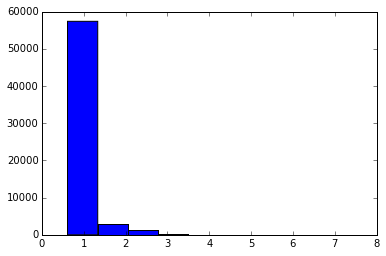

In [36]:
# how about running model on a transformed set of features
plt.hist( np.sqrt(3.0/8.0 + X_train.feat_1) , bins=10)

(array([  5.73890000e+04,   3.80200000e+03,   5.40000000e+02,
          5.10000000e+01,   1.70000000e+01,   5.70000000e+01,
          7.00000000e+00,   8.00000000e+00,   5.00000000e+00,
          2.00000000e+00]),
 array([  0.        ,   1.54960101,   3.09920201,   4.64880302,
          6.19840403,   7.74800504,   9.29760604,  10.84720705,
         12.39680806,  13.94640907,  15.49601007]),
 <a list of 10 Patch objects>)

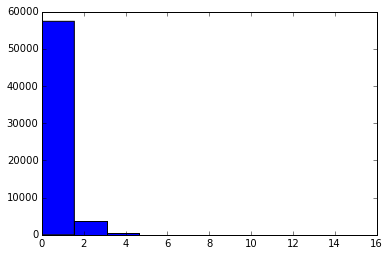

In [41]:
plt.hist( np.power(X_train.feat_1, 2.0/3.0) , bins=10)

(array([  5.90300000e+04,   1.76400000e+03,   6.35000000e+02,
          2.48000000e+02,   1.26000000e+02,   5.00000000e+01,
          1.50000000e+01,   3.00000000e+00,   6.00000000e+00,
          1.00000000e+00]),
 array([ 0.61237244,  1.26789875,  1.92342507,  2.57895138,  3.2344777 ,
         3.89000401,  4.54553033,  5.20105665,  5.85658296,  6.51210928,
         7.16763559]),
 <a list of 10 Patch objects>)

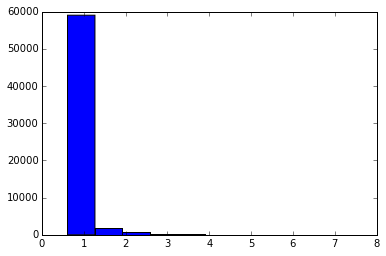

In [37]:
plt.hist( np.sqrt(3.0/8.0 + X_train.feat_2) , bins=10)

In [38]:
np.sqrt(3.0/8.0 + X_train.values)

array([[ 1.17260394,  0.61237244,  0.61237244, ...,  0.61237244,
         0.61237244,  0.61237244],
       [ 0.61237244,  0.61237244,  0.61237244, ...,  0.61237244,
         0.61237244,  0.61237244],
       [ 0.61237244,  0.61237244,  0.61237244, ...,  0.61237244,
         0.61237244,  0.61237244],
       ..., 
       [ 0.61237244,  0.61237244,  0.61237244, ...,  0.61237244,
         0.61237244,  0.61237244],
       [ 1.17260394,  0.61237244,  0.61237244, ...,  1.83711731,
         3.22102468,  0.61237244],
       [ 0.61237244,  0.61237244,  0.61237244, ...,  0.61237244,
         1.5411035 ,  0.61237244]])

In [38]:
rf_model = RandomForestClassifier(n_estimators=500, 
                                    max_depth=40, 
                                    min_samples_leaf=4,
                                    max_features=0.2,
                                    n_jobs = 16)   # running 4 jobs on 4 cores

rf_fit = rf_model.fit(X_train, y_train)

**RF** <br/>
Without calibration: 

    10, 4, 1.0: (0.91251429652300209, 0.94094987502326144)
    40, 4, 1.0: (0.32113909387768685, 0.60717827845190864)
    60, 4, 1.0: (0.31771690448338419, 0.6092925576496071)

With calibration:

    10, 4, 1.0: (0.8356862096817943, 0.83290941743252522)
    40, 4, 1.0: (0.25332064875228538, 0.60348477155300828)
    40, 4, 0.5: (0.23218622276408657, 0.56390228229675121)  # ntree = 300
    20, 4, 0.5: (0.36511831993499538, 0.59753675035788323)  # ntree = 300
    30, 4, 0.5: (0.24953190108702428, 0.56458202652808265)  # ntree = 500
    40, 4, 0.2: (0.23873372608827595, 0.548096151395)       # ntree = 500
    60, 4, 0.2: (0.3088395524161624, 0.56883823507334863)
    60, 4, 1.0: (0.30861626646231655, 0.56614864405879306)
    
With calibration, feature engineering:

    40, 4, 1.0: (0.31838763002858245, 0.57374920366401549)
    40, 4, 0.2: (0.31871012865244258, 0.57653341441142436)
    20, 4, 0.2: (0.3990457711953671, 0.60149029853276681)
    20, 4, 1.0: (0.39945648233825964, 0.60125135890332582)
    60, 4, 1.0: (0.31742162179208683, 0.57465458249032864)
    80, 4, 1.0: (0.31777607892982829, 0.57127352932674513)
    80, 4, 0.2: (0.31740112731579068, 0.56912122044373681)
   
With choice of calibration folds and CV folds

    40, 1.0, 3 (cali folds), 10 (CV folds): (0.25198958289714674, 0.59369842025685893) 
    40, 0.2, 3, 10: (0.23919816211764594, 0.53363464574189834)
    40, 0.2, 2, 10: (0.24310196201783557, 0.54914480378545016)
    (0.23618684491052028, 0.53709911088693973)


**Extra Forests** <br/>
    40, 4, 0.2: (0.4457263724445687, 0.61359812138729486)
    20, 4, 0.2: (0.61621853972602847, 0.70603863875428208)
    20, 4, 1.0: (0.61472915058327471, 0.70238058124675906)

In [111]:
rf_model = RandomForestClassifier(n_estimators=200, 
                                    max_depth=7, 
                                    min_samples_leaf=7,
                                    max_features=0.5)
rf_fit = rf_model.fit(X_train, y_train)

In [112]:
rf_fit

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=7, max_features=0.5,
            max_leaf_nodes=None, min_density=None, min_samples_leaf=7,
            min_samples_split=2, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [115]:
X_test = test.drop(['id'], axis=1)
predicted_test = rf_fit.predict_proba(X_test)

In [116]:
predicted_test[:5]

array([[  2.70372669e-02,   2.84089152e-01,   1.50174340e-01,
          2.30835459e-01,   9.81831444e-03,   1.07760813e-01,
          4.96887087e-02,   7.14070242e-02,   6.91889225e-02],
       [  2.86511083e-02,   2.08242012e-01,   1.20962869e-01,
          1.06313083e-01,   1.01716053e-02,   2.29207343e-01,
          3.76515554e-02,   2.06666135e-01,   5.21342891e-02],
       [  7.84380067e-04,   6.18251546e-04,   5.71601726e-04,
          8.22772943e-05,   1.64245445e-04,   9.90329200e-01,
          1.38779204e-03,   5.10589303e-03,   9.56358857e-04],
       [  1.93503294e-02,   4.32448514e-01,   2.68008976e-01,
          1.00867602e-01,   5.71273233e-03,   3.37295935e-02,
          3.69000466e-02,   5.27885999e-02,   5.01936059e-02],
       [  6.59828963e-02,   1.44940851e-01,   9.25814024e-02,
          2.25283560e-02,   9.90778314e-03,   8.37239250e-02,
          6.36447568e-02,   3.35690661e-01,   1.80999368e-01]])

In [117]:
train.target.unique()

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [118]:
predicted_test = pd.DataFrame(columns=train.target.unique(), data=predicted_test)

In [119]:
predicted_test[:5]

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0.027037,0.284089,0.150174,0.230835,0.009818,0.107761,0.049689,0.071407,0.069189
1,0.028651,0.208242,0.120963,0.106313,0.010172,0.229207,0.037652,0.206666,0.052134
2,0.000784,0.000618,0.000572,0.000082,0.000164,0.990329,0.001388,0.005106,0.000956
3,0.019350,0.432449,0.268009,0.100868,0.005713,0.033730,0.036900,0.052789,0.050194
4,0.065983,0.144941,0.092581,0.022528,0.009908,0.083724,0.063645,0.335691,0.180999


In [122]:
submit = test.filter(['id'], axis=1).join(predicted_test)
submit.to_csv("submissions/04May_RF_02.csv", index=False)

This model scores ￼1.05984 on LB, which is pretty consistent with 5 CV score. 

In [126]:
run_test( (20, 7, 1.0) )

(0.5351777727832947, 0.66301274716062719)

In [141]:
leaves = [5, 10, 20, 30, 45, 60, 80, 100, 120, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]

In [142]:
space = (
    hp.choice( 'max_depth', np.arange(4, 93, step=2)),
    hp.choice( 'min_samples_leaf', leaves ),
    hp.choice( 'max_features', np.arange(0.1, 1.1, step=0.1) )
)

array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200,
       205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265,
       270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330,
       335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395,
       400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460,
       465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525,
       530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595])